<a href="https://colab.research.google.com/github/xvjiarui/GroupViT/blob/master/demo/GroupViT_hf_inference_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

First, let's install HuggingFace Transformers and HuggingFace Datasets.

In [1]:
!pip install -q transformers datasets

     |████████████████████████████████| 3.1 MB 13.5 MB/s 
     |████████████████████████████████| 290 kB 50.7 MB/s 
     |████████████████████████████████| 596 kB 49.5 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 50.6 MB/s 
     |████████████████████████████████| 3.3 MB 40.5 MB/s 
     |████████████████████████████████| 243 kB 52.1 MB/s 
     |████████████████████████████████| 1.1 MB 39.9 MB/s 
     |████████████████████████████████| 132 kB 39.6 MB/s 
     |████████████████████████████████| 192 kB 50.3 MB/s 
     |████████████████████████████████| 160 kB 48.5 MB/s 
     |████████████████████████████████| 271 kB 50.7 MB/s 


## Load model and feature extractor

Here we load the model as well as the feature extractor from the [HuggingFace Hub](https://huggingface.co/). Note that NVIDIA has released several checkpoints, all of which can be found [here](https://huggingface.co/models?other=groupvit). Be sure to play around with them!

The feature extractor can be used to prepare images for the model.

We move the model to GPU if it's available.

In [1]:
from transformers import AutoProcessor, GroupViTModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/groupvit-gccyfcc"
model = GroupViTModel.from_pretrained(model_name)
processor = AutoProcessor.from_pretrained(model_name)
model.to(device)

/home/jiarui/miniconda3/envs/hf/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GroupViTModel(
  (text_model): GroupViTTextTransformer(
    (embeddings): GroupViTTextEmbeddings(
      (token_embedding): Embedding(49408, 256)
      (position_embedding): Embedding(77, 256)
    )
    (encoder): GroupViTTextEncoder(
      (layers): ModuleList(
        (0): GroupViTTextEncoderLayer(
          (self_attn): GroupViTTextAttention(
            (k_proj): Linear(in_features=256, out_features=256, bias=True)
            (v_proj): Linear(in_features=256, out_features=256, bias=True)
            (q_proj): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (mlp): GroupViTMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=256, out_features=1024, bias=True)
            (fc2): Linear(in_features=1024, out_features=256, bias=True)
          )
          (layer_norm

## Prepare image

Here, we load an image from the ADE20k dataset (actually called the [MIT Scene Parsing Benchmark](http://sceneparsing.csail.mit.edu/)), an important benchmark for semantic segmentation. We also load its corresponding ground truth segmentation map.

In [2]:
from datasets import load_dataset
from PIL import Image

# load image + ground truth map
ds = load_dataset("hf-internal-testing/fixtures_ade20k", split="test")
image = Image.open(ds[0]["file"])
segmentation_map = Image.open(ds[1]["file"])
image = image.resize((224, 224))
image = image


No config specified, defaulting to: fixtures_ade20k/image
Reusing dataset fixtures_ade20k (/home/jiarui/.cache/huggingface/datasets/hf-internal-testing___fixtures_ade20k/image/1.9.0/dbb69c3ff2da9a2dcc2de41e8d7ab6543402914292e3d29a4f9701bef817e7db)


We can prepare the image for the model using the feature extractor. It will resize the image + normalize the channels.

In [3]:
def ade_class():
    """ADE20K classes names."""
    return [
         'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 'bed ',
        'windowpane', 'grass', 'cabinet', 'sidewalk', 'person', 'earth',
        'door', 'table', 'mountain', 'plant', 'curtain', 'chair', 'car',
        'water', 'painting', 'sofa', 'shelf', 'house', 'sea', 'mirror', 'rug',
        'field', 'armchair', 'seat', 'fence', 'desk', 'rock', 'wardrobe',
        'lamp', 'bathtub', 'railing', 'cushion', 'base', 'box', 'column',
        'signboard', 'chest of drawers', 'counter', 'sand', 'sink',
        'skyscraper', 'fireplace', 'refrigerator', 'grandstand', 'path',
        'stairs', 'runway', 'case', 'pool table', 'pillow', 'screen door',
        'stairway', 'river', 'bridge', 'bookcase', 'blind', 'coffee table',
        'toilet', 'flower', 'book', 'hill', 'bench', 'countertop', 'stove',
        'palm', 'kitchen island', 'computer', 'swivel chair', 'boat', 'bar',
        'arcade machine', 'hovel', 'bus', 'towel', 'light', 'truck', 'tower',
        'chandelier', 'awning', 'streetlight', 'booth', 'television receiver',
        'airplane', 'dirt track', 'apparel', 'pole', 'land', 'bannister',
        'escalator', 'ottoman', 'bottle', 'buffet', 'poster', 'stage', 'van',
        'ship', 'fountain', 'conveyer belt', 'canopy', 'washer', 'plaything',
        'swimming pool', 'stool', 'barrel', 'basket', 'waterfall', 'tent',
        'bag', 'minibike', 'cradle', 'oven', 'ball', 'food', 'step', 'tank',
        'trade name', 'microwave', 'pot', 'animal', 'bicycle', 'lake',
        'dishwasher', 'screen', 'blanket', 'sculpture', 'hood', 'sconce',
        'vase', 'traffic light', 'tray', 'ashcan', 'fan', 'pier', 'crt screen',
        'plate', 'monitor', 'bulletin board', 'shower', 'radiator', 'glass',
        'clock', 'flag'
    ]

In [4]:
inputs = processor(
    text=[f"a photo of a {word}" for word in ade_class()],
    images=image,
    return_tensors="pt",
    padding=True,
).to(device)

## Forward pass

Next, let's forward the pixel values through the model in order to obtain the logits.

In [5]:
outputs = model(**inputs, output_segmentation=True)
logits = outputs.segmentation_logits

## Visualize

Finally, let's visualize the segmentation map as predicted by the model. Semantic segmentation datasets typically define what is called a "palette", that defines the RGB values to use for each of the classes. 

The ADE20k dataset consists of 150 classes, so the list below has 150 elements.

In [6]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

The model outputs logits of shape `(batch_size, num_labels, height/4, width/4)`.  We first rescale the logits to match the original size of the image using bilinear interpolation. Next, we perform an argmax on the class dimension, and we create a color map which we draw over the image.

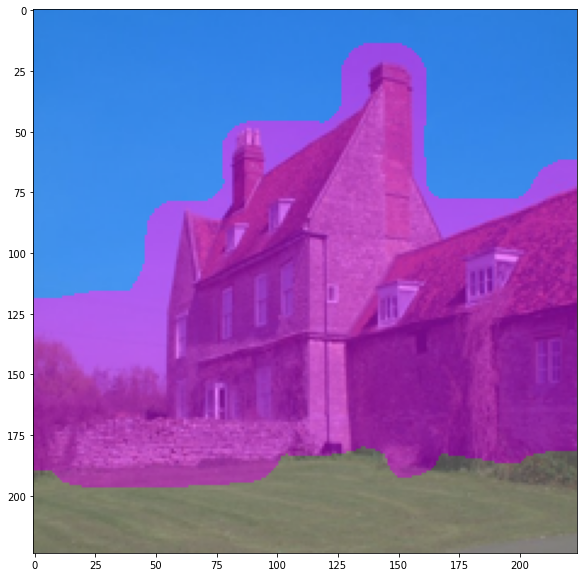

In [7]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
logits = nn.functional.interpolate(logits.detach().cpu(),
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()